# Exploration of Recipe1M+ using clustering
For the subset of recipes used in this example, see the [Recipe1M+](http://pic2recipe.csail.mit.edu/) dataset.
> Marin, J., Biswas, A., Ofli, F., Hynes, N., Salvador, A., Aytar, Y., ... & Torralba, A. (2019). Recipe1m+: A dataset for learning cross-modal embeddings for cooking recipes and food images. IEEE transactions on pattern analysis and machine intelligence, 43(1), 187-203.

See the extracted dataset sample [here](https://unimi2013.sharepoint.com/:u:/s/InformationRetrieval/EaL7kid2qzdCmAA8RO-m5iQBsvCl5cuNIdn0rsJN1FUhSg?e=fdXkkB)

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import os
import nltk

In [3]:
folder = "/Users/flint/Data/recipe/text-sample/"
files = [f for f in os.listdir(folder) if f.endswith('.txt')]
recipes = []
for file in files:
    with open(os.path.join(folder, file), 'r') as data:
        recipes.append(data.read())

In [6]:
print(recipes[0])

Curried Couscous with Broccoli and Feta


Ingredients


 - 1 3/4 cup of water, bottled, generic


 - 1 cup of couscous, dry


 - 1 1/2 cup of broccoli, raw


 - 1/2 cup of fresh red onions, upc: 888670013229


 - 13 cup of carrots, raw


 - 1/4 cup of raisins, seeded


 - 1/4 cup of nuts, cashew nuts, raw


 - 2 tablespoon of vinegar, red wine


 - 1 1/2 teaspoon of oil, olive, salad or cooking


 - 1 tablespoon of sugars, granulated


 - 1 1/2 teaspoon of spices, curry powder


 - 1 teaspoon of spices, ginger, ground


 - 3/4 teaspoon of salt, table


 - 15 ounce of chickpeas (garbanzo beans, bengal gram), mature seeds, raw


 - 3 ounce of cheese, feta


Instructions: 

Bring 1 3/4 cups water to a boil in a medium saucepan; gradually stir in couscous. Remove from heat; cover and let stand 5 minutes. Fluff with a fork. While couscous stands, steam broccoli florets, covered, for 3 minutes or until tender. Combine couscous, broccoli, onion, and next 10 ingredients (onion through chickpea

## Extract ingredients to create a pseudo doc with the ingredients only

In [7]:
import re
from string import punctuation

In [8]:
def ingredient_tokenizer(recipe, pattern=r'-(.*?)\n'):
    pattern = re.compile(pattern)
    ingredients = []
    for ingredient_line in pattern.findall(recipe):
        parts = ingredient_line.split(', ')
        main_ingredient = parts[0].split('of ')[-1]
        tokens = ["".join([x for x in main_ingredient if x not in punctuation])]
        for token in parts[1:]:
            tokens.append("".join(x for x in token if x not in punctuation))
        ingredients += tokens
    return ingredients

In [9]:
corpus = [ingredient_tokenizer(r) for r in recipes]

## Vectorize
Try vectorizing the documents by TfIdf and by LDA

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [12]:
tfidf_vec = TfidfVectorizer(tokenizer=lambda x: x.split())
tfidf = tfidf_vec.fit_transform([" ".join(x) for x in corpus]).toarray()

In [13]:
tfidf.shape

(10000, 1331)

In [14]:
lda_vec = LatentDirichletAllocation(n_components=20)
lda = lda_vec.fit_transform(tfidf)

In [15]:
lda.shape

(10000, 20)

In [17]:
lda[0]

array([0.00720309, 0.00720309, 0.00720309, 0.16231397, 0.00720309,
       0.30177799, 0.00720309, 0.00720309, 0.00720309, 0.00720309,
       0.41345551, 0.00720309, 0.00720309, 0.00720309, 0.00720309,
       0.00720309, 0.00720309, 0.00720309, 0.00720309, 0.00720309])

In [19]:
lda_vec.components_.shape

(20, 1331)

### Explore topics

In [20]:
n_top_words = 6
description = []
feature_names = tfidf_vec.get_feature_names_out()
for topic_idx, topic in enumerate(lda_vec.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    for j, f in enumerate(top_features_ind):
        description.append({
            'topic': "T{}".format(topic_idx),
            'word': top_features[j],
            'score': round(weights[j], 3)
        })
T = pd.DataFrame(description)

In [24]:
T[T.topic=='T3'].sort_values('score', ascending=False)

,topic,word,score
18,T3,nuts,124.638
19,T3,dried,101.122
20,T3,sweetened,72.213
21,T3,seeds,65.912
22,T3,cranberries,65.658
23,T3,uncooked,52.281


### Visualize documents

In [25]:
from sklearn.decomposition import PCA

In [26]:
import matplotlib.pyplot as plt

In [27]:
pca_tfidf = PCA(n_components=2)
Xtfidf = pca_tfidf.fit_transform(tfidf)
pca_lda = PCA(n_components=2)
Xlda = pca_lda.fit_transform(lda)

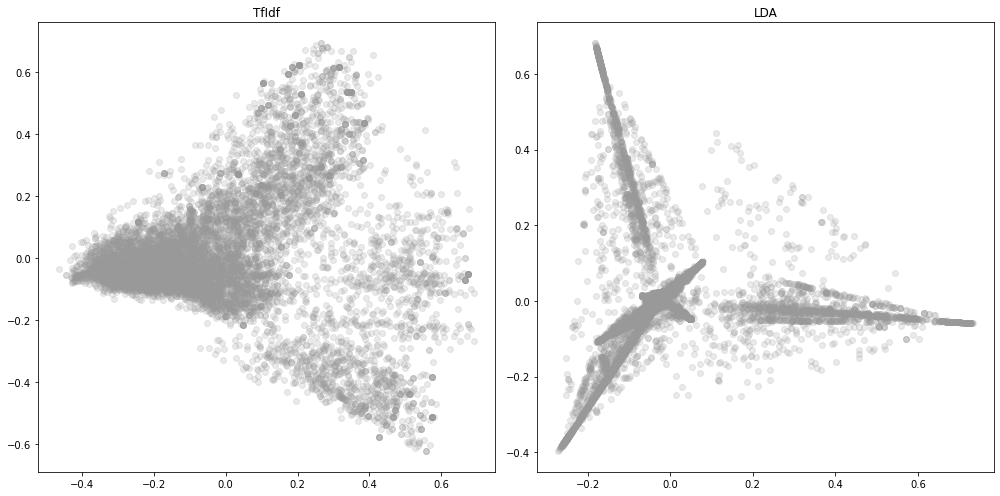

In [28]:
fig, ax = plt.subplots(figsize=(14, 7), ncols=2)
ax[0].scatter(Xtfidf[:,0], Xtfidf[:,1], alpha=0.2, c='#999999')
ax[1].scatter(Xlda[:,0], Xlda[:,1], alpha=0.2, c='#999999')
ax[0].set_title('TfIdf')
ax[1].set_title('LDA')
plt.tight_layout()
plt.show()

## Clustering

In [29]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [30]:
models = {
    'Kmeans': (KMeans, {'n_clusters': 10}),
    'Agglomerative': (AgglomerativeClustering, {'n_clusters': 10})
}

In [31]:
run = list(models.items())

In [32]:
tfidf_clustering = {}
for k, (model, params) in tqdm(run):
    m = model(**params)
    tfidf_clustering[k] = m.fit_predict(tfidf)

  0%|          | 0/2 [00:00<?, ?it/s]

In [33]:
lda_clustering = {}
for k, (model, params) in tqdm(run):
    m = model(**params)
    lda_clustering[k] = m.fit_predict(lda)

  0%|          | 0/2 [00:00<?, ?it/s]

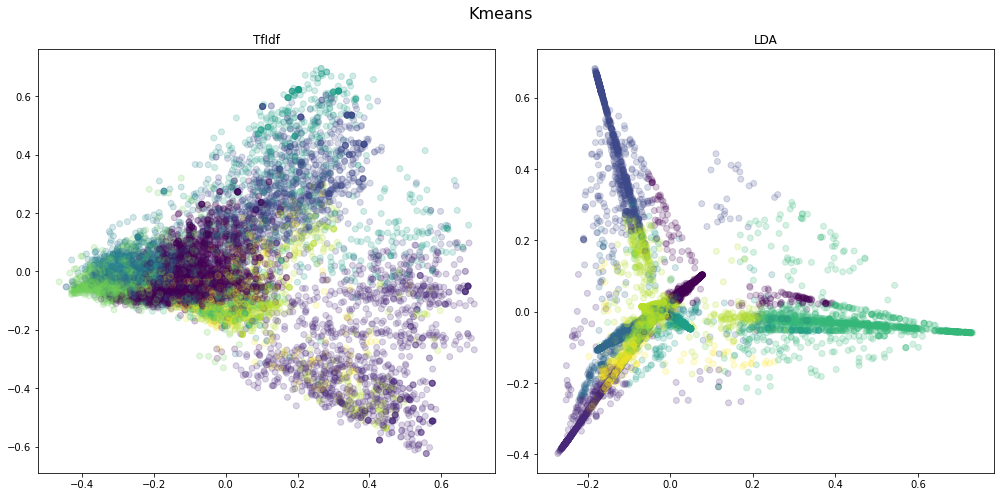

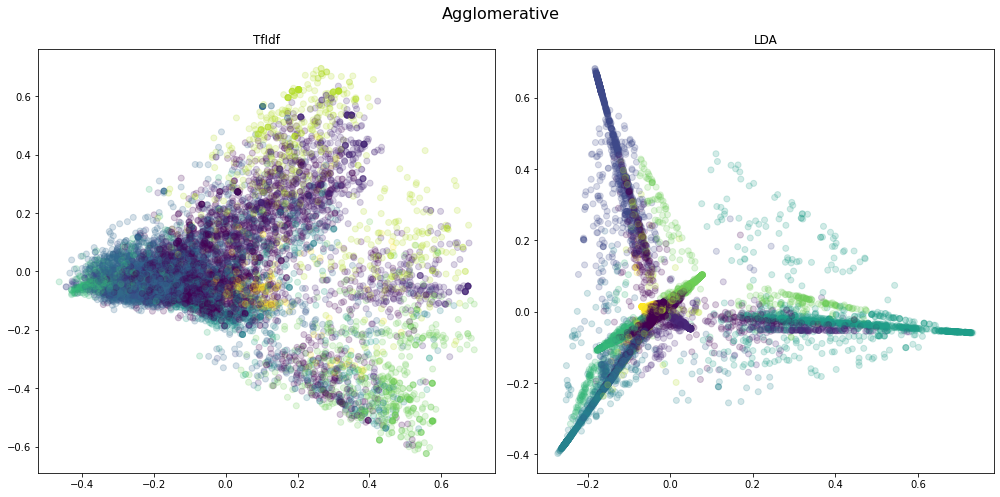

In [34]:
for model in models.keys():
    fig, ax = plt.subplots(figsize=(14, 7), ncols=2)
    fig.suptitle(model, fontsize=16)
    ax[0].scatter(Xtfidf[:,0], Xtfidf[:,1], alpha=0.2, c=tfidf_clustering[model])
    ax[1].scatter(Xlda[:,0], Xlda[:,1], alpha=0.2, c=lda_clustering[model])
    ax[0].set_title('TfIdf')
    ax[1].set_title('LDA')
    plt.tight_layout()
    plt.show()

## Cluster interpretation
**Exercize:** describe clusters by selecting the **top 10 specific and representative** features of each cluster.

In [35]:
from collections import defaultdict

In [43]:
assignment = lda_clustering['Kmeans']
assignment

array([8, 9, 1, ..., 5, 9, 2], dtype=int32)

In [44]:
vocabulary = tfidf_vec.get_feature_names_out()

In [45]:
def doc_vocabulary(doc_id, top_w=10):
    words_scores = sorted(enumerate(tfidf[doc_id]), key=lambda x: -x[1])
    return [(vocabulary[wid], score) for wid, score in words_scores[:top_w]]

In [46]:
cluster_desc = defaultdict(lambda: defaultdict(lambda: 0))
for doc_id, cluster_label in enumerate(assignment):
    for word, score in doc_vocabulary(doc_id):
        cluster_desc[cluster_label][word] += score

In [48]:
CL = pd.Series(cluster_desc[1])
CL.sort_values(ascending=False).iloc[:20]

spices       283.787883
pepper        83.407370
powder        78.675602
seed          58.950853
dried         57.886796
cayenne       51.634448
garlic        49.725830
cumin         45.749949
black         43.549311
paprika       42.899001
onion         37.368954
chili         36.532439
grassfed      35.134925
oregano       34.864535
beef          34.323572
raw           33.894147
red           33.579166
thyme         27.856901
ground        26.263870
coriander     23.058121
dtype: float64

**Exercize:** exploit the cluster to speed-up document search using the cluster pruning technique [https://nlp.stanford.edu/IR-book/html/htmledition/cluster-pruning-1.html](https://nlp.stanford.edu/IR-book/html/htmledition/cluster-pruning-1.html)